# Method Presentation 

We present a comparative analysis of the performance of classical RNN networks, including Vanilla, GRU and LSTM models, versus the novel architecture proposed by Michael Rotman and Lior Wolf named Shuffling RNN. We addressed both regression as the main problem and classification problem as further experiment. The regression dataset used in the study consists of a multivariate time series related to weather conditions. Specifically, the time series consisted of four variables: humidity, pressure, temperature, and wind speed.
The classification dataset is a text collection of movie reviews evaluated favorable or critical.

The main issue that limits the performance of traditional recurrent neural network models is the exploding or vanishing gradient. While GRU and LSTM utilize a gating mechanism to stabilize the gradient flow between subsequent hidden states, SRNN identifies the source of the problem in the matrix multiplication over the previously seen hidden states. Since the first input of a sequence is processed more times than later ones there appeare to be a gap in the way each time step influences the network weights during training. Consider the framework for a Vanilla RNN: $h_t = \sigma(W_1 h_{t-1} + W_2 x_t) =\sigma(z_t)$ where $\sigma$ is a nonlinear activation function. Using Backpropagation through time we obtain
\begin{equation}
\frac{\partial L}{\partial h_t} =\sum_{t=1}^{T} \frac{\partial L}{\partial h_t} \frac{\partial h_t}{\partial W_1}= \sum_{t=1}^{T} \frac{\partial L}{\partial h_t}\sigma'(z_t)h_{t-1}
\end{equation}
Depending on the maximal eigenvalue of $W_1$, the repeated multiplication by $W_1$ in $\frac{\partial L}{\partial h_t}$ may lead to exponential growth or decay in the gradient. SRNN focuses on constraining the weight matrix $W_1$ to be orthogonal. The method benefits from this property, since the successive applications of $W_1$ do not increase nor decrease the norm of the hidden state vector, such that the gradients with respect to the hidden state do not suffer from an exponential growth or decay. Therefore, the method can be applied without the use of any gradient clipping schemes.\\The SRNN architecture consists of two hidden-state processing components, the learned network b that is comprised of fully connected layers, and a fixed permutation matrix W. At each time step, the layer receives two input signals: the hidden state of the previous time step, $h_{t−1}$ and the input at the current time step $x_t$. 
\begin{equation}
h_t = \sigma(W_p h_{t-1} + b(x_t)) \equiv \sigma(z_t)
\end{equation}
Network b is given by the sum of a Multilayer Perceprtron and a single affine layer with a sigmoid activation function.
\begin{equation}
b(x_t) = f_r(x_t) \odot \sigma(W_s x_t + b_s)
\end{equation}
The output of the network at time step t is obtained by using a single affine layer.

![](SRNN.png)

## Import Libraries

The project has been built using the following libraries: \textit{Pythorch, Scikit Learn, Pandas, Matplotlib, Numpy, Torchtext.

In [16]:
import torch
from torch import nn
import torch.nn.functional as F
import torch
import pandas as pd
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import nltk

# Regression

## Utils

In [17]:
ARCHIVE_PATH = "DailyDelhiClimateTrain.csv"
MODELS_PATH = "./"
PLOTS_PATH = "./"

To study a time series, it is common to extract a sequence of values from the series and try to predict the last item of the sequence. The process is then repeated by sliding the sequence window by one step until the end of the time series is reached. This preprocessing is made by the class Data.

In [18]:
#old class
class SequentialDataset:
    def __init__(self, dataset):
        self.dataset = dataset
        self.index = 0
        self.max = dataset.size()[0]

    def GetItems(self, i):
        if (self.index > self.max - 2):
            self.index = 0
        if (i + self.index > self.max - 1):
            #x = self.dataset[self.index:self.max - 1]
            #y = self.dataset[self.max - 1]
            self.index = 0
            # return x, y
        x = self.dataset[self.index:self.index + i - 1]
        y = self.dataset[self.index + i - 1]
        self.index += i
        return x, y

# Init of the dataset


def InitDataset(path):
    df = pd.read_csv(path, header=0)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    window_size = pd.Timedelta(days=7)
    time_series = df.set_index('date').rolling(window=window_size).mean()
    time_series = time_series.dropna()
    # normalization
    #time_series = (time_series-time_series.mean())/time_series.std()
    time_series_array = torch.from_numpy(time_series.to_numpy())
    column_number = time_series_array.size()[1]
    row_number = time_series_array.size()[0]

    return row_number, column_number, SequentialDataset(time_series_array), time_series_array
# Dataset containing the time series


class Data(Dataset):
    def __init__(self, train_path, sequence_length=100, max_dim=0):

        size, _, data, tensor_data = InitDataset(train_path)

        self.dataset = []
        self.targets = []
        if sequence_length > size:
            sequence_length = 100

        for i in range(tensor_data.size()[0] - sequence_length):
            x = tensor_data[i:sequence_length + i]
            t = tensor_data[i + sequence_length]
            self.dataset.append(x)
            self.targets.append(t)

    def __getitem__(self, index):
        x = self.dataset[index]
        return x, self.targets[index]

    def __len__(self):
        return len(self.dataset)

# function to save the model


def Save(model, PATH):
    torch.save([model.kwargs, model.state_dict()], PATH)

# function to load the saved model


def Load_s(MODEL, PATH):
    kwargs, state = torch.load(PATH)
    model = MODEL(**kwargs)
    model.load_state_dict(state)
    return model


## RNNs


Neural Networks have been implemented by scratch. When not declared the following default hyperparameters will be used: hidden size = 128, batch size = 32, epochs = 100, sequence length = 100.

In [19]:
# Our RNN model


class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=256, batch_size=32):
        super(RNN, self).__init__()
        self.batch_size = batch_size
        self.kwargs = {'input_size': input_size, 'output_size': output_size,
                       'hidden_size': hidden_size, 'batch_size': batch_size}
        # Defining some parameters
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    # the forward function
    def forward(self, input, hidden=None):
        input = input.permute(1, 0, 2)
        if hidden == None:
            hidden = self.init_hidden(input.size()[1])
        for element in input:
            combined = torch.cat((element, hidden), 1)
            hidden = self.i2h(combined)
        output = self.h2o(hidden)
        return output, hidden

    # init the hidden state function
    def init_hidden(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        hidden = torch.zeros(batch_size, self.hidden_size)
        return hidden

# our SRNN implementation


class SRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=256, MLP_len=3, batch_size=32, shift=1):
        super(SRNN, self).__init__()
        self.kwargs = {'input_size': input_size, 'output_size': output_size,
                       'hidden_size': hidden_size, 'batch_size': batch_size, 'shift': shift}
        self.shift = shift
        # Defining some parameters
        self.MLP_len = MLP_len
        self.hidden_size = hidden_size
        self.h2o = nn.Linear(hidden_size, output_size, dtype=torch.float)
        self.batch_size = batch_size
        self.layerMLP = nn.Sequential(
            nn.Linear(input_size, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, hidden_size),
            nn.Sigmoid()
        )
        self.linearH = nn.Linear(
            hidden_size, hidden_size, bias=False, dtype=torch.float)
        self.linearX = nn.Linear(input_size, hidden_size, dtype=torch.float)

    # forward function
    def forward(self, input, hidden=None):
        input = input.permute(1, 0, 2)
        if hidden == None:
            hidden = self.init_hidden(input.size()[1])
        for x in input:
            pre_hidden = torch.roll(hidden, self.shift, -1)
            linear_x = self.linearX(x)
            fx = self.layerMLP(x)
            b = torch.mul(fx, torch.sigmoid(linear_x))
            hidden = F.relu(pre_hidden + b)
        output = self.h2o(hidden)
        return output, hidden

    # init the hidden state function
    def init_hidden(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        hidden = torch.zeros(batch_size, self.hidden_size)
        return hidden

# Our GRU nn


class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=256, batch_size=32):
        super(GRU, self).__init__()
        self.kwargs = {'input_size': input_size, 'output_size': output_size,
                       'hidden_size': hidden_size, 'batch_size': batch_size}
        self.batch_size = batch_size
        # Defining some parameters
        self.hidden_size = hidden_size
        self.c2r = nn.Linear(input_size + hidden_size, hidden_size)
        self.c2z = nn.Linear(input_size + hidden_size, hidden_size)
        self.c2t = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    # forward function
    def forward(self, input, hidden=None):
        input = input.permute(1, 0, 2)
        if hidden == None:
            hidden = self.init_hidden(input.size()[1])
        for element in input:
            combined = torch.cat((element, hidden), 1)
            r = torch.sigmoid(self.c2r(combined))
            z = torch.sigmoid(self.c2z(combined))
            combined_tilde = torch.cat((element, torch.mul(r, hidden)), 1)
            hidden_tilde = torch.tanh(self.c2t(combined_tilde))
            hidden = torch.mul(z, hidden) + torch.mul(1 - z, hidden_tilde)
        output = self.h2o(hidden)
        return output, hidden

    # init the hidden state function
    def init_hidden(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        hidden = torch.zeros(batch_size, self.hidden_size)
        return hidden

# Our LSTM model


class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=256, batch_size=32):
        super(LSTM, self).__init__()
        self.kwargs = {'input_size': input_size, 'output_size': output_size,
                       'hidden_size': hidden_size, 'batch_size': batch_size}
        self.batch_size = batch_size
        # Defining some parameters
        self.hidden_size = hidden_size
        self.c2i = nn.Linear(input_size + hidden_size, hidden_size)
        self.c2f = nn.Linear(input_size + hidden_size, hidden_size)
        self.c2ot = nn.Linear(input_size + hidden_size, hidden_size)
        self.c2ct = nn.Linear(input_size + hidden_size, hidden_size)
        self.c22o = nn.Linear(hidden_size*2, output_size)

    # forward function
    def forward(self, input, hidden=None, covariate=None):
        input = input.permute(1, 0, 2)
        if hidden == None:
            hidden = self.init_hidden(input.size()[1])
        if covariate == None:
            covariate = self.init_covariate(input.size()[1])
        for element in input:
            combined = torch.cat((element, hidden), 1)
            i = torch.sigmoid(self.c2i(combined))
            f = torch.sigmoid(self.c2f(combined))
            o = torch.sigmoid(self.c2ot(combined))
            c_tilde = torch.tanh(self.c2ct(combined))
            covariate = torch.mul(f, covariate) + torch.mul(i, c_tilde)
            hidden = torch.mul(o, torch.tanh(covariate))
        output = self.c22o(torch.cat((hidden, covariate), 1))
        return output, hidden

    def init_hidden(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        hidden = torch.zeros(batch_size, self.hidden_size)
        return hidden

    def init_covariate(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        covariate = torch.zeros(batch_size, self.hidden_size)
        return covariate

# test net to see the results of pythorch GRU


class Net2(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=256, batch_size=32):
        super(Net2, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.GRU = GRU(input_size, output_size, hidden_size)

    def forward(self, input, hidden=None, covariate=None):
        output, hidden = self.GRU.forward(input)
        return output, hidden

    def init_hidden(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        hidden = torch.zeros(batch_size, self.hidden_size)
        return hidden

# another test model


class Net3(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=256, batch_size=32):
        super(Net3, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.GRU = nn.GRU(input_size, hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden=None, covariate=None):
        input = input.permute(1, 0, 2)
        if hidden == None:
            hidden = self.init_hidden(input.size()[1])
        _, hidden = self.GRU.forward(input)
        output = self.fc(hidden)
        return output, hidden

    def init_hidden(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        hidden = torch.zeros(batch_size, self.hidden_size)
        return hidden


## Test Functions

Here we test the selected model with the chosen hyperparameters. The minibatch extraction is made through a dataloader with shuffling enabled. We have chosen to use the MSE and the BCE loss functions (one for regression and the other for classification) and the Adam optimizer in order to control gradient explosion.

In [20]:

def Test(batch_size = 32, save = False, plot = False, path = ARCHIVE_PATH, hidden_size = 256, epochs = 15000, arg = None, learning_rate = 0.0001):

    _, size, _, tensor_data = InitDataset(path)

    models = []
    models_name = []

    # choosing the model
    if arg != None:

        if "r" in arg:
            models.append(RNN(size, size, hidden_size, batch_size=batch_size))
            models_name.append("RNN")
            print("rnn")

        if "s" in arg:
            models.append(SRNN(size, size, hidden_size, batch_size=batch_size))
            models_name.append("SRNN")
            print("srnn")

        if "g" in arg:
            models.append(GRU(size, size, hidden_size, batch_size=batch_size))
            models_name.append("GRU")
            print("gru")

        if "l" in arg:
            models.append(LSTM(size, size, hidden_size, batch_size=batch_size))
            models_name.append("LSTM")
            print("lstm")

        if "t" in arg:
            models.append(Net2(size, size, hidden_size, batch_size=batch_size))
            models_name.append("TEST2")
            print("test2")
            models.append(Net3(size, size, hidden_size, batch_size=batch_size))
            models_name.append("TEST3")
            print("test3")

    if len(models) == 0:
        models.append(RNN(size, size, hidden_size, batch_size=batch_size))
        models_name.append("RNN")


    train_dataset = Data(path)
    train_dataloader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True)

    j = -1

    total_losses = []

    for model in models:
        losses = []
        j += 0
        # loss function
        criterion = nn.MSELoss()
        # optimier algorithm
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # training process
        for i in tqdm(range(epochs)):
            for local_batch, local_labels in train_dataloader:
                outputs, hiddens = model.forward(local_batch.float())
                loss = criterion(outputs.float(), local_labels.float())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
        # add the loss to the list
        total_losses.append(losses)

    # plot the loss
    j = 0
    if plot == True:
        for x in total_losses:
            plt.plot(x, label=models_name[j])
            j += 1
        plt.legend(loc="upper left")
        plt.grid()
        plt.show()
    # save the models
    j = 0
    if save == True:
        for model in models:

            Save(model, MODELS_PATH+models_name[j])
            j += 1
    # test the model on a single value
    j = 0
    for model in models:
        j += 1
        print("actual value: ", tensor_data[100])
        output, _ = model.forward(tensor_data[:100].unsqueeze(0).float())
        print("predicted one: ", output)


In [21]:
def test_with_parameters(plot_name,
                         plot_value,
                         hidden_size=128,
                         batch_size=32,
                         epochs=100,
                         learning_rate=0.0001,
                         sequence_length=100,
                         path=ARCHIVE_PATH,
                         ):

    # we need the size to init the neural network
    _, size, _, _ = InitDataset(path)
    # initializing the dataset and the dataloader
    train_dataset = Data(path, sequence_length=sequence_length)
    train_dataloader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True)
    # adding the models we want to plot to a list
    models = []
    models_name = []
    models.append(SRNN(size, size, hidden_size, batch_size=batch_size))
    models_name.append("SRNN")
    models.append(LSTM(size, size, hidden_size, batch_size=batch_size))
    models_name.append("LSTM")
    #models.append(Net2(size,size,hidden_size, batch_size = batch_size))
    models.append(GRU(size, size, hidden_size, batch_size=batch_size))
    models_name.append("GRU")
    total_losses = []
    j = 0
    for model in models:
        losses = []
        j += 0
        # loss function
        criterion = nn.MSELoss()
        # optimier algorithm
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        # training step
        for i in tqdm(range(epochs)):
            for local_batch, local_labels in train_dataloader:
                outputs, _ = model.forward(local_batch.float())
                loss = criterion(outputs.float(), local_labels.float())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
        # adding the loss to the list
        total_losses.append(losses)
    # ploting the results
    j = 0
    for x in total_losses:
        plt.plot(x, label=models_name[j])
        j += 1
    plt.title(plot_name + str(plot_value), fontsize=15)
    # Adding axis titles
    plt.ylabel('MSE', fontsize=12)
    plt.xlabel('Training steps', fontsize=12)
    plt.grid()
    plt.legend()
    plt.plot( bbox_inches='tight')
    plt.show()
   


def shift_variation_test(hidden_size=128,
                         batch_size=32,
                         epochs=100,
                         learning_rate=0.0001,
                         sequence_length=100,
                         path=ARCHIVE_PATH,
                         ):
    # we need the sizes of the neural network
    _, size, _, _ = InitDataset(path)
    # initializing the dataset and dataloader
    train_dataset = Data(path, sequence_length=sequence_length)
    train_dataloader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True)
    # adding the models to plot
    models = []
    models_name = []
    models.append(SRNN(size, size, hidden_size,
                  batch_size=batch_size, shift=0))
    models_name.append("SRNN with shift = 0")
    models.append(SRNN(size, size, hidden_size,
                  batch_size=batch_size, shift=1))
    models_name.append("SRNN with shift = 1")
    models.append(SRNN(size, size, hidden_size,
                  batch_size=batch_size, shift=2))
    models_name.append("SRNN with shift = 2")
    models.append(SRNN(size, size, hidden_size,
                  batch_size=batch_size, shift=3))
    models_name.append("SRNN with shift = 3")
    total_losses = []
    j = 0
    for model in models:
        losses = []
        j += 0
        # loss function
        criterion = nn.MSELoss()
        # optimier algorithm
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        # training process
        for i in tqdm(range(epochs)):
            for local_batch, local_labels in train_dataloader:
                outputs, hiddens = model.forward(local_batch.float())
                loss = criterion(outputs.float(), local_labels.float())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
        # adding the loss to the list
        total_losses.append(losses)
    # ploting the results
    j = 0
    for x in total_losses:
        plt.plot(x, label=models_name[j])
        j += 1
    plt.title('shift variation', fontsize=15)
    # Adding axis title
    plt.ylabel('MSE', fontsize=12)
    plt.xlabel('Training steps', fontsize=12)
    plt.grid()
    plt.legend()
    plt.plot(ìbbox_inches='tight')
    plt.show()
# in this function we do 3 test by changing 1 variable each time.
# the first test is changing the sequence lenght, the second one
# is changing the hidden size and the third one is changing the
# shift variation of srrn.


rnn


100%|██████████| 1000/1000 [09:46<00:00,  1.71it/s]


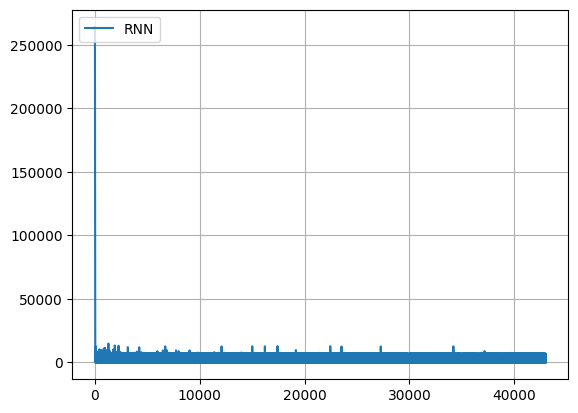

actual value:  tensor([  28.4973,   28.6714,    9.3720, 1006.0844], dtype=torch.float64)
predicted one:  tensor([[ 27.2748,  31.0005,  10.1080, 998.9521]], grad_fn=<AddmmBackward0>)


In [22]:
Test(epochs = 1000, arg = "r", plot = True)

## Experiments

We have conducted some experiments to test different hyperparameters and the effectiveness of the model. 
As a first set of trials we trained the four models varying the sequence lenght in the range 50,100,200,400 and the hidden size in the range 64,128,256,512. The SRNN has been tested with different shift values between 0 and 3.

100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


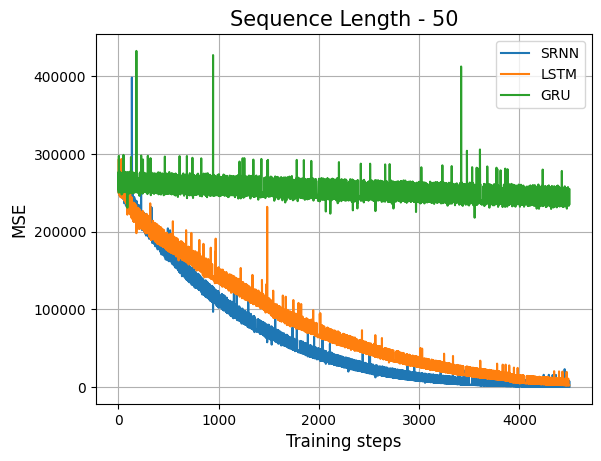

100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


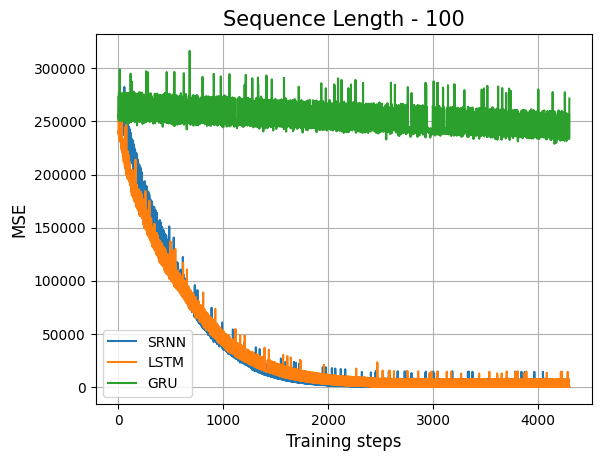

100%|██████████| 100/100 [36:41<00:00, 22.02s/it]  


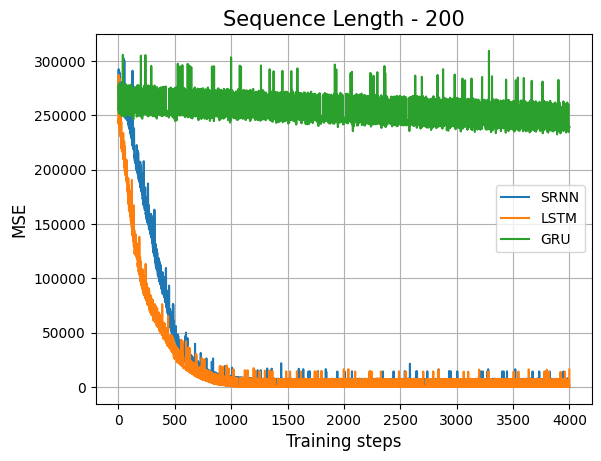

100%|██████████| 100/100 [33:40<00:00, 20.20s/it]  


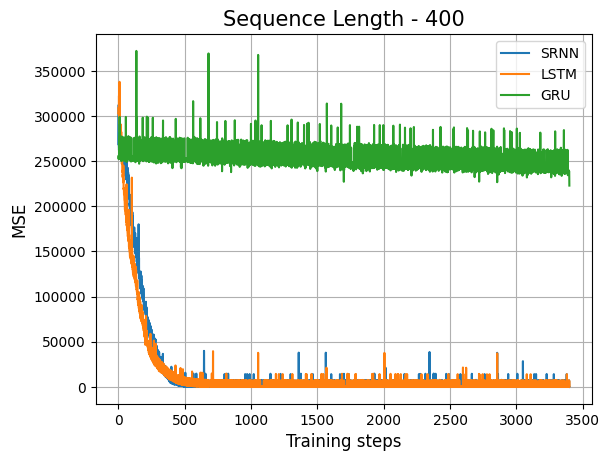

In [23]:
sequences_length = [50, 100, 200, 400]
for sequence_length in sequences_length:
        test_with_parameters("Sequence Length - ",
                             sequence_length, sequence_length=sequence_length, epochs=100)

100%|██████████| 100/100 [33:29<00:00, 20.10s/it]  


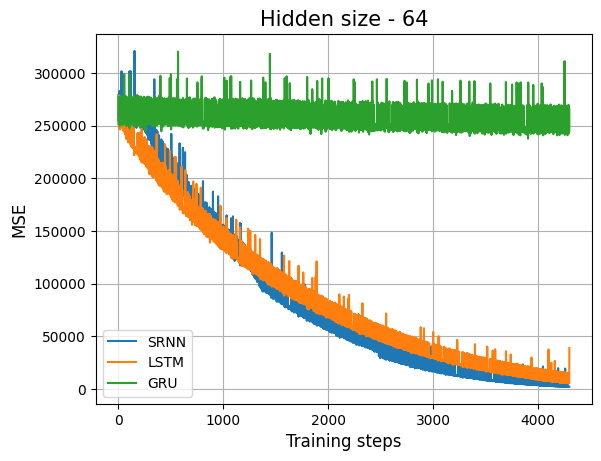

100%|██████████| 100/100 [15:53<00:00,  9.54s/it]  


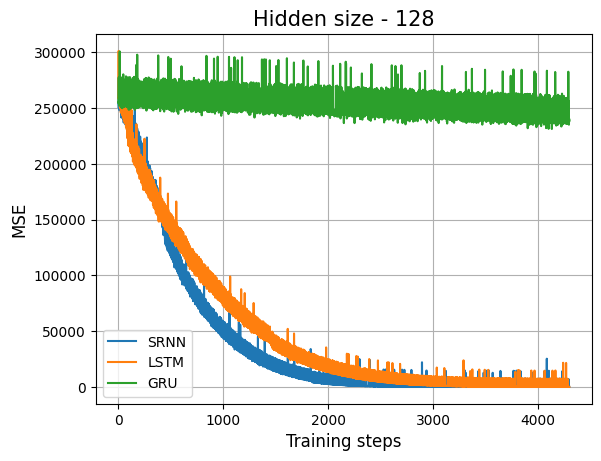

100%|██████████| 100/100 [28:35<00:00, 17.15s/it]  


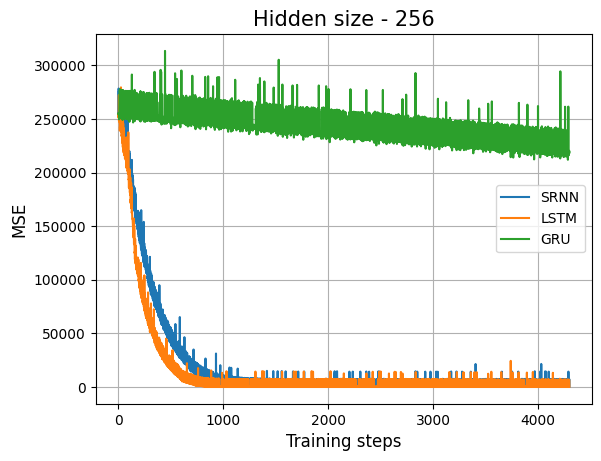

100%|██████████| 100/100 [35:00<00:00, 21.00s/it]  


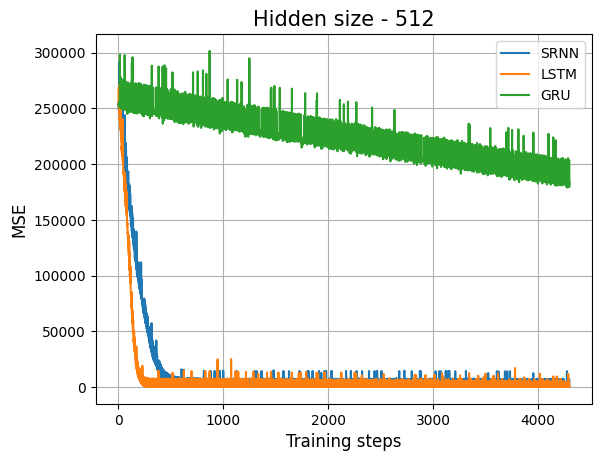

In [24]:
hidden_sizes = [64, 128, 256, 512]
for hidden_size in hidden_sizes:
        test_with_parameters("Hidden size - ", hidden_size,
                             hidden_size=hidden_size, epochs=100)

100%|██████████| 100/100 [03:29<00:00,  2.09s/it]


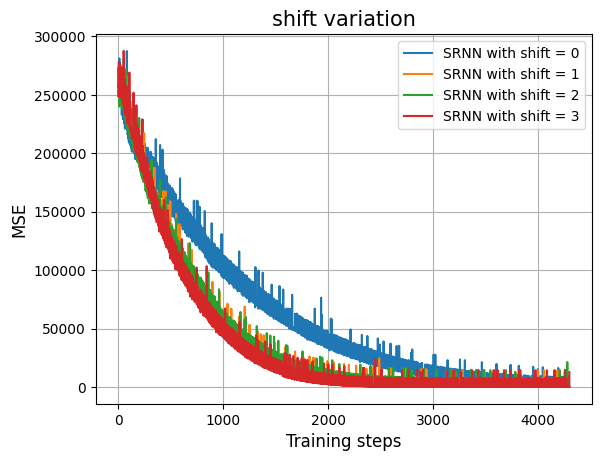

In [25]:
shift_variation_test(epochs=100)

# Classification

As a conclusive test we have applied the SRNN in a text binary classification problem. The dataset consists of movie reviews labelled as positive or negatives. For every review a vocabulary associate each word to a token which are then passed through the network sequentially. As for regression we executed experiments varying sequence length and shift value in SRNN for the classification problem.

## Utils

In [26]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [27]:
ARCHIVE_PATH_CLASSIFICATION = "IMDB_Dataset.csv"
MODELS_PATH = "./"
PLOTS_PATH = "./"

In [28]:
nltk.download('punkt')


def accuracy(tensor_t, tensor_y):
    tensor_y = (tensor_y >= 0.5)
    return accuracy_score(tensor_t, tensor_y)


def create_words_tensor(max_len, number_of_features, frasi, vocab, tokenizer, dataset_dim=1000):
    number_of_elements = min(dataset_dim, len(frasi))
    X = torch.zeros(number_of_elements, max_len, number_of_features)

    for i in range(dataset_dim):
        words = tokenizer(frasi[i])
        iters = min(len(words), max_len)
        for j in range(iters):
            X[i][j] = vocab[words[j].lower()]

    return X


def InitDataset_c(path):

    df = pd.read_csv(path, header=0)

    frasi = np.array(df['review'])
    target = np.array(df['sentiment'])

    tokenizer = get_tokenizer('basic_english')

    def yield_tokens():
        for example in frasi:
            tokens = tokenizer(example)
            yield tokens

    token_generator = yield_tokens()

    vocab = build_vocab_from_iterator(token_generator)

    vocab.get_stoi()

    max_len = 60

    dataset_dim = 1000

    X = create_words_tensor(max_len, 1, frasi, vocab,
                            tokenizer, dataset_dim=dataset_dim)

    encoder = LabelEncoder()
    y_encoded = torch.tensor(encoder.fit_transform(target))

    return dataset_dim, 1, X, y_encoded


class Data_C(Dataset):
    def __init__(self, train_path):

        size, features, X, t = InitDataset_c(train_path)

        self.dataset = []
        self.targets = []

        for i in range(size):
            self.dataset.append(X[i])
            self.targets.append(t[i])

    def __getitem__(self, index):
        x = self.dataset[index]
        return x, self.targets[index]

    def __len__(self):
        return len(self.dataset)


def Save_c(model, PATH):
    torch.save([model.kwargs, model.state_dict()], PATH)


def Load_sc(MODEL, PATH):
    kwargs, state = torch.load(PATH)
    model = MODEL(**kwargs)
    model.load_state_dict(state)
    return model


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


## RNNs

In [29]:
# Our RNN implementation


class RNN_c(nn.Module):
    def __init__(self, input_size, hidden_size=256, batch_size=32):
        super(RNN_c, self).__init__()

        self.batch_size = batch_size

        self.kwargs = {'input_size': input_size,
                       'hidden_size': hidden_size, 'batch_size': batch_size}

        # Defining some parameters
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    # forward function
    def forward(self, input, hidden=None):
        input = input.permute(1, 0, 2)
        if hidden == None:
            hidden = self.init_hidden(input.size()[1])
        for element in input:
            combined = torch.cat((element, hidden), 1)
            hidden = self.i2h(combined)
        output = self.sigmoid(self.h2o(hidden))
        return output, hidden

    # the function to init the hidden
    def init_hidden(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        hidden = torch.zeros(batch_size, self.hidden_size)
        return hidden

# Our SRNN implementation


class SRNN_c(nn.Module):
    def __init__(self, input_size, hidden_size=256, MLP_len=3, batch_size=32, shift=1):
        super(SRNN_c, self).__init__()

        self.kwargs = {'input_size': input_size, 'hidden_size': hidden_size,
                       'batch_size': batch_size, 'shift': shift}
        self.shift = shift
        self.MLP_len = MLP_len
        self.hidden_size = hidden_size
        self.h2o = nn.Linear(hidden_size, 1, dtype=torch.float)
        self.sigmoid = nn.Sigmoid()
        self.batch_size = batch_size
        self.layerMLP = nn.Sequential(
            nn.Linear(input_size, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, hidden_size),
            nn.Sigmoid()
        )
        self.linearH = nn.Linear(
            hidden_size, hidden_size, bias=False, dtype=torch.float)
        self.linearX = nn.Linear(input_size, hidden_size, dtype=torch.float)

    # forward function
    def forward(self, input, hidden=None):
        input = input.permute(1, 0, 2)
        if hidden == None:
            hidden = self.init_hidden(input.size()[1])
        for x in input:
            pre_hidden = torch.roll(hidden, self.shift, -1)
            linear_x = self.linearX(x)
            fx = self.layerMLP(x)
            b = torch.mul(fx, torch.sigmoid(linear_x))
            hidden = F.relu(pre_hidden + b)
        output = self.sigmoid(self.h2o(hidden))
        return output, hidden

    # function to init hidden state
    def init_hidden(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        hidden = torch.zeros(batch_size, self.hidden_size)
        return hidden

# Our GRU implementation


class GRU_c(nn.Module):
    def __init__(self, input_size, hidden_size=256, batch_size=32):
        super(GRU_c, self).__init__()
        self.kwargs = {'input_size': input_size,
                       'hidden_size': hidden_size, 'batch_size': batch_size}
        self.batch_size = batch_size
        # Defining some parameters
        self.hidden_size = hidden_size
        self.c2r = nn.Linear(input_size + hidden_size, hidden_size)
        self.c2z = nn.Linear(input_size + hidden_size, hidden_size)
        self.c2t = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    # the forward function
    def forward(self, input, hidden=None):
        input = input.permute(1, 0, 2)
        if hidden == None:
            hidden = self.init_hidden(input.size()[1])
        for element in input:
            combined = torch.cat((element, hidden), 1)
            r = torch.sigmoid(self.c2r(combined))
            z = torch.sigmoid(self.c2z(combined))
            combined_tilde = torch.cat((element, torch.mul(r, hidden)), 1)
            hidden_tilde = torch.tanh(self.c2t(combined_tilde))
            hidden = torch.mul(z, hidden) + torch.mul(1 - z, hidden_tilde)
        output = self.sigmoid(self.h2o(hidden))
        return output, hidden

    # the function to init the hidden state
    def init_hidden(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        hidden = torch.zeros(batch_size, self.hidden_size)
        return hidden

# Our LSTM implementation


class LSTM_c(nn.Module):
    def __init__(self, input_size, hidden_size=256, batch_size=32):
        super(LSTM_c, self).__init__()
        self.kwargs = {'input_size': input_size,
                       'hidden_size': hidden_size, 'batch_size': batch_size}
        self.batch_size = batch_size
        # Defining some parameters
        self.hidden_size = hidden_size
        self.c2i = nn.Linear(input_size + hidden_size, hidden_size)
        self.c2f = nn.Linear(input_size + hidden_size, hidden_size)
        self.c2ot = nn.Linear(input_size + hidden_size, hidden_size)
        self.c2ct = nn.Linear(input_size + hidden_size, hidden_size)
        self.c22o = nn.Linear(hidden_size*2, 1)
        self.sigmoid = nn.Sigmoid()

    # The forward function
    def forward(self, input, hidden=None, covariate=None):
        input = input.permute(1, 0, 2)
        if hidden == None:
            hidden = self.init_hidden(input.size()[1])
        if covariate == None:
            covariate = self.init_covariate(input.size()[1])
        for element in input:
            combined = torch.cat((element, hidden), 1)
            i = torch.sigmoid(self.c2i(combined))
            f = torch.sigmoid(self.c2f(combined))
            o = torch.sigmoid(self.c2ot(combined))
            c_tilde = torch.tanh(self.c2ct(combined))
            covariate = torch.mul(f, covariate) + torch.mul(i, c_tilde)
            hidden = torch.mul(o, torch.tanh(covariate))
        output = self.sigmoid(self.c22o(torch.cat((hidden, covariate), 1)))
        return output, hidden

    # the function to init the hidden state
    def init_hidden(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        hidden = torch.zeros(batch_size, self.hidden_size)
        return hidden

    def init_covariate(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        covariate = torch.zeros(batch_size, self.hidden_size)
        return covariate

# A neural network to test the pythorch GRU


class Net2_c(nn.Module):
    def __init__(self, input_size, hidden_size=256, batch_size=32):
        super(Net2_c, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.GRU = GRU_c(input_size, 1, hidden_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input, hidden=None, covariate=None):
        output, hidden = self.GRU.forward(input)
        return self.sigmoid(output), hidden

    def init_hidden(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        hidden = torch.zeros(batch_size, self.hidden_size)
        return hidden

# Another test neural network


class Net3_c(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=256, batch_size=32):
        super(Net3_c, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.GRU = nn.GRU(input_size, hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    # the forward function
    def forward(self, input, hidden=None, covariate=None):
        input = input.permute(1, 0, 2)
        if hidden == None:
            hidden = self.init_hidden(input.size()[1])
        _, hidden = self.GRU.forward(input)
        output = self.sigmoid(self.fc(hidden))
        return output, hidden

    # the function to init the hidden state
    def init_hidden(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size
        hidden = torch.zeros(batch_size, self.hidden_size)
        return hidden


## Test Functions

In [30]:
def Test_c(batch_size = 32, save = False, plot = False, path = ARCHIVE_PATH_CLASSIFICATION, hidden_size = 256, epochs = 15000, arg = None, learning_rate = 0.0001):

    _, features, X, t = InitDataset_c(path)
    models = []
    models_name = []
    # choosing the model
    if arg != None:
        if "r" in arg:
            models.append(RNN_c(features, hidden_size, batch_size=batch_size))
            models_name.append("RNN")
            print("rnn")
        if "s" in arg:
            models.append(SRNN_c(features, hidden_size, batch_size=batch_size))
            models_name.append("SRNN")
            print("srnn")
        if "g" in arg:
            models.append(GRU_c(features, hidden_size, batch_size=batch_size))
            models_name.append("GRU")
            print("gru")
        if "l" in arg:
            models.append(LSTM_c(features, hidden_size, batch_size=batch_size))
            models_name.append("LSTM")
            print("lstm")
        if "t" in arg:
            models.append(Net2_c(features, hidden_size, batch_size=batch_size))
            models_name.append("TEST2")
            print("test2")
            models.append(Net3_c(features, hidden_size, batch_size=batch_size))
            models_name.append("TEST3")
            print("test3")
    if len(models) == 0:
        models.append(RNN_c(features, hidden_size, batch_size=batch_size))
        models_name.append("RNN")
    train_dataset = Data_C(path)
    train_dataloader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True)
    j = -1
    total_losses = []
    for model in models:
        losses = []
        j += 0
        # loss function
        criterion = nn.BCELoss()
        # optimier algorithm
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        # training process
        for i in tqdm(range(epochs)):
            for local_batch, local_labels in train_dataloader:
                outputs, hiddens = model.forward(local_batch.float())
                loss = criterion(outputs.float(), torch.unsqueeze(
                    local_labels.float(), 1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
        # adding the loss to the list
        total_losses.append(losses)
    # plot the loss
    j = 0
    if plot == True:
        for x in total_losses:
            plt.plot(x, label=models_name[j])
            j += 1
        plt.legend(loc="upper left")
        plt.grid()
        plt.show()
    # save the models
    j = 0
    if save == True:
        for model in models:
            Save(model, MODELS_PATH+models_name[j])
            j += 1
    A = X[:100]
    miar = t[:100]
    for models in models:
        output, _ = model.forward(A.float())
        print(accuracy(miar, output))


In [31]:

def test_with_parameters_c(plot_name,
                         plot_value,
                         hidden_size=128,
                         batch_size=32,
                         epochs=1000,
                         learning_rate=0.0001,
                         sequence_length=100,
                         path=ARCHIVE_PATH_CLASSIFICATION,
                         ):

    _, features, X, t = InitDataset_c(path)

    train_dataset = Data_C(path)
    train_dataloader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True)

    models = []
    models_name = []
    models.append(SRNN_c(features, hidden_size, batch_size=batch_size))
    models_name.append("SRNN")
    models.append(LSTM_c(features, hidden_size, batch_size=batch_size))
    models_name.append("LSTM")
    models.append(Net2_c(features, hidden_size, batch_size=batch_size))
    #models.append(GRU_C(features, hidden_size, batch_size = batch_size))
    models_name.append("GRU")

    total_losses = []

    j = 0

    for model in models:
        losses = []
        j += 0
        # loss function
        criterion = nn.BCELoss()
        # optimier algorithm
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        # initializing hidden layer
        hidden = model.init_hidden()

        for i in tqdm(range(epochs)):
            for local_batch, local_labels in train_dataloader:
                outputs, hiddens = model.forward(local_batch.float())
                loss = criterion(outputs.float(), torch.unsqueeze(
                    local_labels.float(), 1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())

        total_losses.append(losses)

    j = 0
    for x in total_losses:
        plt.plot(x, label=models_name[j])
        j += 1

    plt.title(plot_name + str(plot_value), fontsize=15)
    # Adding axis title
    plt.ylabel('BCE', fontsize=12)
    plt.xlabel('Training steps', fontsize=12)
    plt.grid()
    plt.legend()
    plt.plot( bbox_inches='tight')
    plt.show()
   


def shift_variation_test_c(
    hidden_size=128,
    batch_size=32,
    epochs=1000,
    learning_rate=0.001,
    path=ARCHIVE_PATH_CLASSIFICATION
):

    _, features, X, t = InitDataset_c(path)

    train_dataset = Data_C(path)
    train_dataloader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True)

    models = []
    models_name = []
    models.append(SRNN_c(features, hidden_size, batch_size=batch_size, shift=0))
    models_name.append("SRNN with shift = 0")
    models.append(SRNN_c(features, hidden_size, batch_size=batch_size, shift=1))
    models_name.append("SRNN with shift = 1")
    models.append(SRNN_c(features, hidden_size, batch_size=batch_size, shift=2))
    models_name.append("SRNN with shift = 2")
    models.append(SRNN_c(features, hidden_size, batch_size=batch_size, shift=3))
    models_name.append("SRNN with shift = 3")

    total_losses = []

    j = 0

    for model in models:
        losses = []
        mses = []
        j += 0
        # loss function
        criterion = nn.BCELoss()
        # optimier algorithm
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        for i in tqdm(range(epochs)):
            for local_batch, local_labels in train_dataloader:
                outputs, hiddens = model.forward(local_batch.float())
                loss = criterion(outputs.float(), torch.unsqueeze(
                    local_labels.float(), 1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())

        total_losses.append(losses)

    j = 0
    for x in total_losses:
        plt.plot(x, label=models_name[j])
        j += 1

    plt.title('shift variation', fontsize=15)
    # Adding axis title
    plt.ylabel('BCE', fontsize=12)
    plt.xlabel('Training steps', fontsize=12)
    plt.grid()
    plt.legend()
    plt.plot(bbox_inches='tight')
    plt.show()



rnn


100%|██████████| 1000/1000 [59:04<00:00,  3.54s/it]  


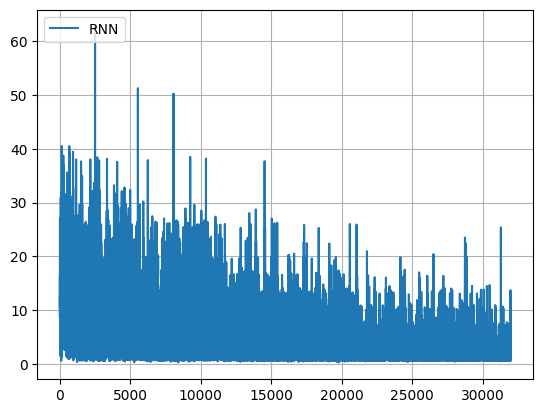

0.57


In [32]:
Test_c(epochs = 1000, arg = "r", plot = True)

## Experiments

100%|██████████| 100/100 [26:45<00:00, 16.05s/it]  


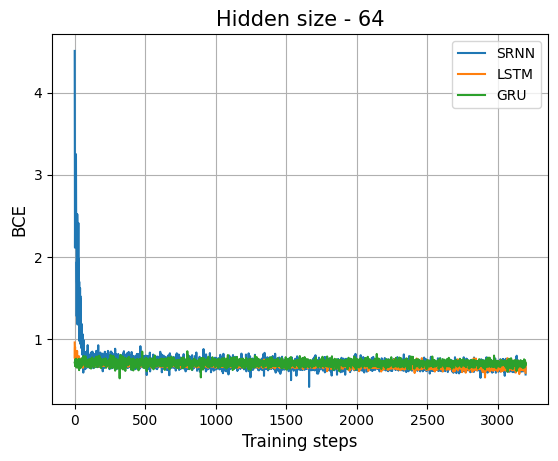

100%|██████████| 100/100 [05:56<00:00,  3.57s/it] 


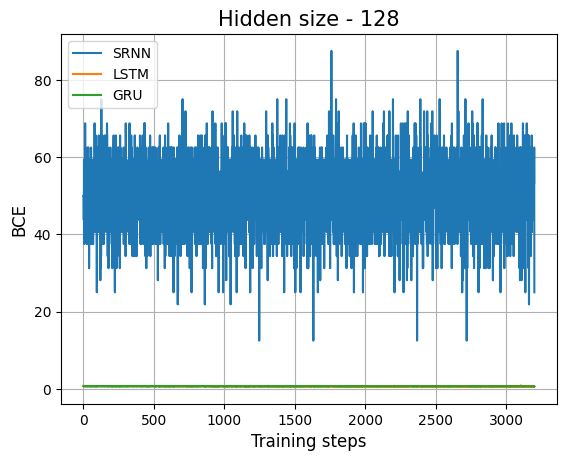

100%|██████████| 100/100 [52:33<00:00, 31.53s/it]  


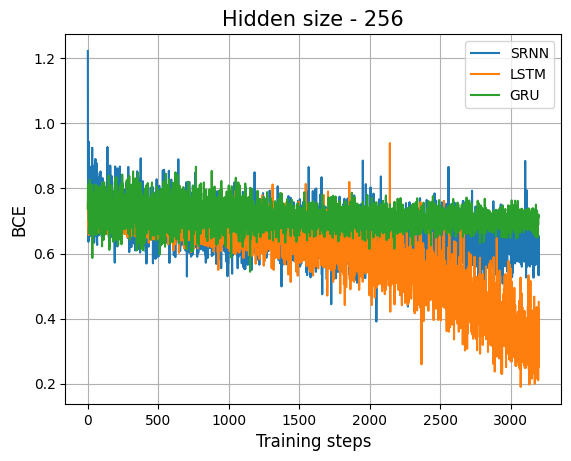

100%|██████████| 100/100 [00:29<00:00,  3.38it/s]


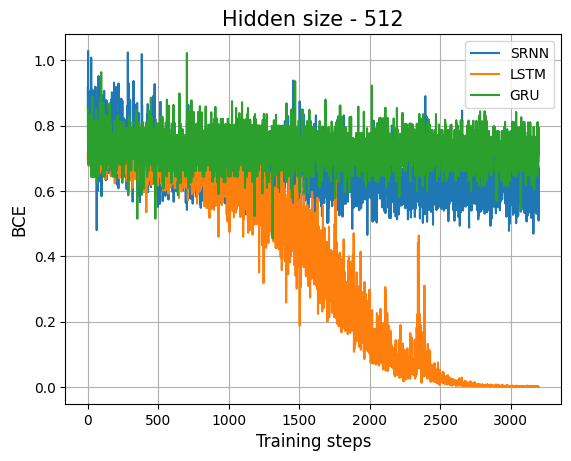

100%|██████████| 100/100 [00:29<00:00,  3.37it/s]


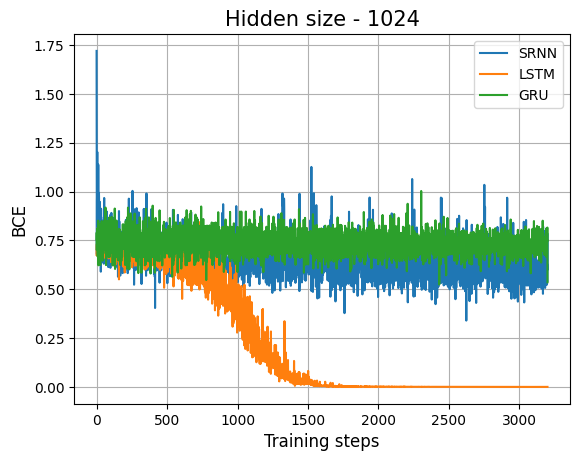

In [33]:
hidden_sizes = [64, 128, 256, 512, 1024]
for hidden_size in hidden_sizes:
    test_with_parameters_c("Hidden size - ", hidden_size,
                        hidden_size=hidden_size, epochs=100)

100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


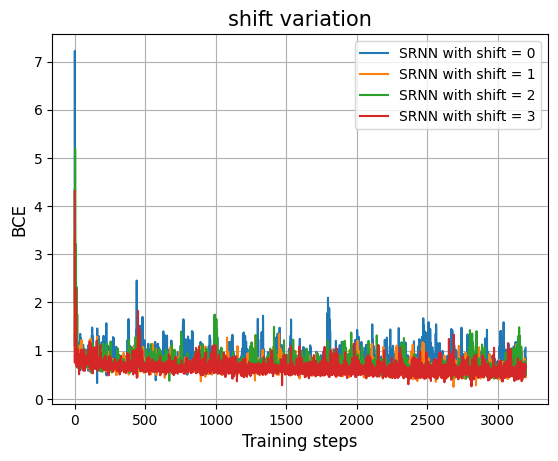

In [35]:
shift_variation_test_c(epochs=100, hidden_size=512)

## Results

The empirical findings of the project are consistent with the theoretical expectations displaying improved outcomes using SRNN.
GRU Model needs longer training: in early trials the network gave the appearence of not functioning properly until training time has been extended. On the other hand SRNN performs better on shorter training. LSTM proves itself to be a competitive alternative.
LSTM shows the best performance with short hidden size but as it increaeses the model is progressively outperformed by SRNN.
An opposite trend is displayed varying the sequence length. The longest the sequence the more is preferrable to use LSTM over SRNN. In both experiments  GRU shows shortcomes  in comparison with LSTM and SRNN.
Regarding different shifts of the permutation matrix we acknowledged a direct proportionality between the shift size and training time. In the long term big shifts lead to more advantegeous accomplishments. 
In relation to the classification problem LSTM model exhibits its superiority in handling longer sequences in comparison to other models. Its accuracy depicts an exponential decay, making it a suitable solution for classification. SRNN may be chosen for fast training but this is unlikely to happen in real applications.
Despite big shifts seems to strength SRNN, in the long the long term perfromance in classification using different values are comparable.